In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.decomposition import PCA
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
from numpy.random import uniform, normal

In [2]:
def path_length(x, y, z):
    """
    Distance traveled in 3D.
    """
    
    x_sq_dist = np.square(np.diff(x,  axis=0))
    y_sq_dist = np.square(np.diff(y,  axis=0))
    z_sq_dist = np.square(np.diff(z,  axis=0))

    dist = np.sqrt(np.sum(np.dstack((x_sq_dist, y_sq_dist, z_sq_dist)), axis=-1))[0]

    # total distance traveled
    return np.sum(dist)

def economy_of_volume(x, y, z, length_norm=True):
    """
    Economy of Volume (EOV) as described by

    Oropesa, Ignacio, et al. "EVA: laparoscopic instrument tracking based on endoscopic
    video analysis for psychomotor skills assessment." Surgical endoscopy 27.3 (2013): 1029-1039.

    Parameters
    ----------
    x : list or array
        x-axis coordinates.

    y : list or array
        y-axis coordinates.

    z : list or array
        z-axis coordinates.

    length_norm : boolean, (default True)
        If True, then the numerator of EOV is divided by the length of the array, or path length. Otherwise,
        EOV is returned without being divided by path length.

    Returns
    -------
    economy of volume : float
    """
    
    if length_norm:
        pl = path_length(x, y, z)
        return np.cbrt((np.max(x) - np.min(x))*(np.max(y) - np.min(y))*(np.max(z) - np.min(z))) / pl
    else:
        return np.cbrt((np.max(x) - np.min(x))*(np.max(y) - np.min(y))*(np.max(z) - np.min(z)))


def geometric_mean_eigenvalues(x, y, z, length_norm=True):
    """
    Geometric Mean of Eigenvalues (GE)
    """
    if length_norm:
        pl = path_length(x, y, z)
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.cbrt(np.prod(my_pca.explained_variance_))/pl
    else:
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.cbrt(np.prod(my_pca.explained_variance_))
    
def arithmetic_mean_eigenvalues(x, y, z, length_norm=True):
    """
    Arithmetic Mean of Eigenvalues (AE)
    """
    if length_norm:
        pl = path_length(x, y, z)
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.mean(my_pca.explained_variance_) / pl
    else:
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.mean(my_pca.explained_variance_)
    
def max_of_eigenvalues(x, y, z, length_norm=True):
    """
    Max of the Eigenvalues (ME)
    """
    if length_norm:
        pl = path_length(x, y, z)
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.max(my_pca.explained_variance_) / pl
    else:
        my_pca = PCA(n_components=3).fit(np.column_stack((x,y,z)))
        return np.max(my_pca.explained_variance_)
    
def space_occupancy(x, y, z, metric='eov'):
    """
    Helper function to compute metrics for spatial occupancy and distribution.
    """
    
    if metric == 'eov':
        val = economy_of_volume(x, y, z, length_norm=True)
    elif metric == 'eov_nolen':
        val = economy_of_volume(x, y, z, length_norm=False)
    elif metric == 'ge':
        val = geometric_mean_eigenvalues(x, y, z, length_norm=True)
    elif metric == 'ge_nolen':
        val = geometric_mean_eigenvalues(x, y, z, length_norm=False)
    elif metric == 'ae':
        val = arithmetic_mean_eigenvalues(x, y, z, length_norm=True)
    elif metric == 'ae_nolen':
        val = arithmetic_mean_eigenvalues(x, y, z, length_norm=False)
    elif metric == 'me':
        val = max_of_eigenvalues(x, y, z, length_norm=True)
    elif metric == 'me_nolen':
        val = max_of_eigenvalues(x, y, z, length_norm=False)
    else:
        raise ValueError('Check that input for metric is correct.')
        
    return val

def segmentation(x, y, z, alpha=0.2, med_filt_w_size=3):
    """
    Automated Targeting Phase Segmentation Algorithm implementation.

    Parameters
    ----------
    x : list or array
        x-axis coordinates.

    y : list or array
        y-axis coordinates.

    z : list or array
        z-axis coordinates.

    alpha : float (default 0.2)
        Parameter used to determine the distance threhsold along displacement d.

    med_filt_w_size : int (default 3)
        Window size for the median filter on the velocity profile prior to segmentation. Depending
        on your dataset, different values for this or an entirely different filtering method
        may be preferred.

    Returns
    -------
    Tuple of (values of d : list, threshold index along d : int, phase segmentation index : int)
    """
    
    # start of trajectory
    start = {
        'x' : x[0],
        'y' : y[0],
        'z' : z[0]
    }
    
    # end of trajectory
    end = {
        'x' : x[-1],
        'y' : y[-1],
        'z' : z[-1]
    }
    
    # projection
    denom = np.sqrt((end['x']-start['x'])**2 + (end['y']-start['y'])**2 + (end['z']-start['z'])**2)
    A = {
        'x' : (end['x']-start['x']) / denom,
        'y' : (end['y']-start['y']) / denom,
        'z' : (end['z']-start['z']) / denom
    }
    
    d_values = []
    for (_x, _y, _z) in zip(x, y, z):
        b_i = {
            'x' : _x - start['x'],
            'y' : _y - start['y'],
            'z' : _z - start['z']
        }
        
        d_i = b_i['x'] * A['x'] + b_i['y'] * A['y'] + b_i['z'] * A['z']
        
        d_values.append(d_i)
        
    # variable distance thresholding
    d_thresh = d_values[-1] - alpha * d_values[-1]
    d_thresh_indx = [i for i,d in enumerate(d_values) if d >= d_thresh][0]
    
    # get velocity profile
    vel = compute_velocity(x, y, z)[0]
    vel = median_filter(vel, size=med_filt_w_size)

    # max velocity point
    p1 = np.array([np.argmax(vel), vel[np.argmax(vel)]])
    # point where object grab occurs
    p2 = np.array([len(vel), vel[-1]])

    orthogonal_dist = []
    for i, v in enumerate(vel):
        p3 = np.array([i, v])
        orthogonal_dist.append(np.abs(np.cross(p2-p1,p3-p1))/np.linalg.norm(p2-p1))

    # point most distant from line segment connecting velocity peak and end of velocity time series
    # this point is after d_thresh
    segmentation_index = np.argmax(orthogonal_dist[d_thresh_indx:]) + d_thresh_indx
    
    return d_values, d_thresh_indx, segmentation_index

def compute_velocity(x_coords, y_coords, z_coords, frame_rate=30):
    # computes velocity from position
    x_squared_dist = np.square(np.diff(x_coords,  axis=0))
    y_squared_dist = np.square(np.diff(y_coords,  axis=0))
    z_squared_dist = np.square(np.diff(z_coords,  axis=0))

    return np.sqrt(np.sum(np.dstack((x_squared_dist, y_squared_dist, z_squared_dist)), axis=-1)) / (1/frame_rate)

## Usage

In [3]:
# trajectory (b) from Figure 3 of the paper
mat = loadmat('test_trajectory.mat')
x_col = mat['x'][0]
y_col = mat['y'][0]
z_col = mat['z'][0]

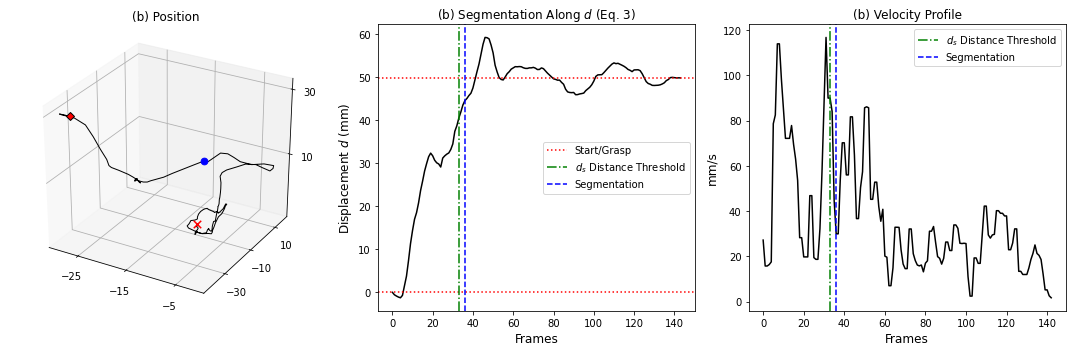

In [4]:
# plot the trajectory and results of segmentation

fig = plt.figure(figsize=(15,5))

d_vals, d_thresh_indx, seg_indx = segmentation(x_col, y_col, z_col, 0.2, 3)

ax = fig.add_subplot(1,3,1, projection='3d')

ax.scatter(x_col[seg_indx], y_col[seg_indx], z_col[seg_indx], marker='o', c='b', s=45)
ax.scatter(x_col[-1], y_col[-1], z_col[-1], marker='x', c='r', s=55)
ax.plot(x_col, y_col, z_col, color='k', marker='D', markerfacecolor='r', markevery=[0], linewidth=1)

ax.set_title('(b) Position', y=1.08)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_yticks(ax.get_yticks()[::2])
ax.set_zticks(ax.get_zticks()[::2])

ax = fig.add_subplot(1,3,2)

ax.plot(d_vals, '-k')
ax.axhline(d_vals[0], color='r', linestyle=':', label='Start/Grasp')
ax.axhline(d_vals[-1], color='r', linestyle=':')
ax.axvline(d_thresh_indx, color='g', linestyle='-.', label='$d_s$ Distance Threshold')
ax.axvline(seg_indx, color='b', linestyle='--', label='Segmentation')
ax.set_xlabel('Frames', fontsize=12)
ax.set_ylabel('Displacement $d$ (mm)', fontsize=12)

ax.set_title('(b) Segmentation Along $d$ (Eq. 3)')
ax.legend()

ax = fig.add_subplot(1,3,3)

ax.plot(median_filter(compute_velocity(x_col, y_col, z_col)[0], 3), '-k')

ax.set_title('(b) Velocity Profile')
ax.set_xlabel('Frames', fontsize=12)
ax.set_ylabel('mm/s', fontsize=12)
ax.axvline(d_thresh_indx, color='g', linestyle='-.', label='$d_s$ Distance Threshold')
ax.axvline(seg_indx, c='b', ls='--', label='Segmentation')
ax.legend()
ax.tick_params()

plt.tight_layout()
plt.show()

In [7]:
# example of getting space occupancy based on segmentation
print('Geometric Mean of Eigenvalues', space_occupancy(x_col[seg_indx:], y_col[seg_indx:], z_col[seg_indx:], metric='ge_nolen'))
print('Non Length Normalized EOV', space_occupancy(x_col[seg_indx:], y_col[seg_indx:], z_col[seg_indx:], metric='eov_nolen'))

Geometric Mean of Eigenvalues 7.117399688647525
Non Length Normalized EOV 18.312929513127045


## Synthetic Data Example

In [8]:
# Note that no random seed is set, so values will change every time

uni = {
    'x' : MinMaxScaler().fit_transform(uniform(size=150).reshape(-1,1)).flatten(),
    'y' : MinMaxScaler().fit_transform(uniform(size=150).reshape(-1,1)).flatten(),
    'z' : MinMaxScaler().fit_transform(uniform(size=150).reshape(-1,1)).flatten()
}

gaus = {
    'x' : MinMaxScaler().fit_transform(normal(size=150, scale=1).reshape(-1,1)).flatten(),
    'y' : MinMaxScaler().fit_transform(normal(size=150, scale=1).reshape(-1,1)).flatten(),
    'z' : MinMaxScaler().fit_transform(normal(size=150, scale=1).reshape(-1,1)).flatten()
}

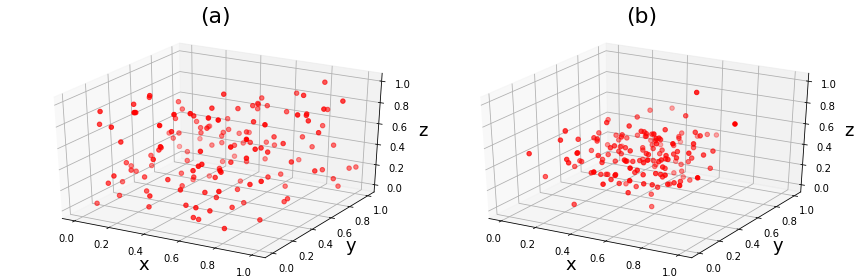

In [9]:
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(wspace=.01)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(uni['x'], uni['y'], uni['z'], color='red')
ax.set_title('(a)', fontsize=22, y=1.08)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(gaus['x'], gaus['y'], gaus['z'], color='red')
ax.set_title('(b)', fontsize=22, y=1.08)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

plt.tight_layout()
plt.show()

In [10]:
print("Point Cloud (a) values:\n")
print("GE:", space_occupancy(uni['x'], uni['y'], uni['z'], 'ge_nolen'))
print("EOV:", space_occupancy(uni['x'], uni['y'], uni['z'], 'eov_nolen'))
print("AE:", space_occupancy(uni['x'], uni['y'], uni['z'], 'ae_nolen'))
print("ME:", space_occupancy(uni['x'], uni['y'], uni['z'], 'me_nolen'))

print("\nPoint Cloud (b) values:\n")
print("GE:", space_occupancy(gaus['x'], gaus['y'], gaus['z'], 'ge_nolen'))
print("EOV:", space_occupancy(gaus['x'], gaus['y'], gaus['z'], 'eov_nolen'))
print("AE:", space_occupancy(gaus['x'], gaus['y'], gaus['z'], 'ae_nolen'))
print("ME:", space_occupancy(gaus['x'], gaus['y'], gaus['z'], 'me_nolen'))

Point Cloud (a) values:

GE: 0.08441098608914617
EOV: 1.0
AE: 0.08549753359919693
ME: 0.10159689112643466

Point Cloud (b) values:

GE: 0.029710029371923657
EOV: 1.0
AE: 0.030439591386397593
ME: 0.038360671813409825
